Задача - сделать сервис рекоммендаций музыкальных треков на основе данных по трекам и взаимодействиям пользователей

Этапы и комментарии

 Этап 1 - загрузка первичных данных
 загружаем таблицы tracks,catalog_names,interactions
 общий вывод - присутствуют сквозные идентификаторы, основная проблема - не полностью заполнен контент с жанрами (не все треки присутствуют в справочнике)

 Этап 2 - EDA
 матрица U_I будет очень большой размерности
 для экономии ресурсов можно вначале отфильтровать пользователей - убрать единичные прослушивание, похожих на роботов и все расчеты сделать только на части данных
 после финализации прототипа сделать расчет на полном объеме и посмотреть на качество
 далее добавляем необходимые признаки для удобства и сохраняем в items и events

 Этап 3 - рекоммендации
 разбиение данных - делаем глобальное разделение (global time split)
 считаем топ популярных треков - с учетом вводной по активному росту сервиса считать будем фильтруя период (например за 2е полугодие/ноябрь месяц)
 персональные рекомендации - воспользуемся als моделью, предварительно закодируем идентификаторы (пользователь id, трек id)
 похожие - для расчета похожих треков воспользуемся методом similar_items уже рассчитанной als_model
 ансамбль моделей - собираем кандидаты (популярные и персональные рекомендации), далее строим модель для получения финальных рекоммендаций


# Инициализация

Загружаем библиотеки необходимые для выполнения кода ноутбука.

In [1]:
import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import time
import scipy
import sklearn.preprocessing
import numpy as np
import pickle
from implicit.als import AlternatingLeastSquares
from catboost import CatBoostClassifier, Pool

In [2]:
start_time = time.time()

# === ЭТАП 1 ===

# Загрузка первичных данных

Загружаем первичные данные из файлов:
- tracks.parquet
- catalog_names.parquet
- interactions.parquet

In [3]:
tracks = pd.read_parquet("data/tracks.parquet")

In [4]:
catalog_names=pd.read_parquet("data/catalog_names.parquet")

In [5]:
interactions=pd.read_parquet("data/interactions.parquet")

In [6]:
stage1_import=time.time()

# Обзор данных

Проверяем данные, есть ли с ними явные проблемы.

# Таблица 1 - треки
Данные о треках — в файле tracks.parquet:
 - track_id — идентификатор музыкального трека;
 - albums — список идентификаторов альбомов, содержащих трек;
 - artists — список идентификаторов исполнителей трека;
 - genres — список идентификаторов жанров, к которым принадлежит трек.

In [7]:
tracks.head(3)

,track_id,albums,artists,genres
0,26,"[3, 2490753]",[16],"[11, 21]"
1,38,"[3, 2490753]",[16],"[11, 21]"
2,135,"[12, 214, 2490809]",[84],[11]


 - поля - id, альбомы, артисты, жанры
 - числовой id, данные в столбцах кроме track_id содержат массивы

In [ ]:
tracks['track_id'].nunique() #1 млн треков

1000000

In [9]:
# ключевое поле заполнено без пропусков
tracks['track_id'].isna().sum()

0

In [10]:
#пустые значения в полях albums, artists, genres
genres_miss=len(tracks[(tracks['genres'].str.len() == 0)])
artist_miss=len(tracks[(tracks['artists'].str.len() == 0)])
albums_miss=len(tracks[(tracks['albums'].str.len() == 0)])
all=len(tracks)

f"пусто артистов - {artist_miss}, пусто альбомов - {albums_miss}, пусто жанров - {genres_miss}, доля пропусков - {(artist_miss+albums_miss+genres_miss)/all}"

'пусто артистов - 15369, пусто альбомов - 18, пусто жанров - 3687, доля пропусков - 0.019074'

# Таблица 2 - контент 
(имена артистов, названия альбомов, треков и жанров в файле catalog_names.parquet):
 - id — идентификатор одной из каталожных единиц (трека, альбома, исполнителя, жанра);
 - type — тип идентификатора;
 - name — имя (название) каталожной единицы.

In [11]:
catalog_names.head(3)

,id,type,name
0,3,album,Taller Children
1,12,album,Wild Young Hearts
2,13,album,Lonesome Crow


числовой id

In [12]:
catalog_names['id'].isna().sum()

0

нет пропусков по id

In [13]:
len(catalog_names)-catalog_names['id'].nunique()

35774

есть дубли по id - посмотим подробнее

In [14]:
catalog_names.groupby('id').agg({'type':'count'}).reset_index().sort_values(by='type',ascending=False).head(10)

,id,type
171531,669527,3
12457,22057,3
16243,29496,3
3057,4474,3
99792,299507,3
45989,85456,3
159049,629396,3
12471,22076,3
122510,432903,3
71957,168409,3


In [15]:
##пример дубля по ключу - id не уникальные, разделим для удобства на отдельные справочники
catalog_names.query('id==669527')

,id,type,name
79463,669527,album,What Should I Write About?
696583,669527,artist,Off the Record Karaoke
887371,669527,track,Left Outside Alone


In [16]:
catalog_names['type'].unique()

array(['album', 'artist', 'genre', 'track'], dtype=object)

In [17]:
genre_cat=catalog_names.query('type=="genre"')
album_cat=catalog_names.query('type=="album"')
artist_cat=catalog_names.query('type=="artist"')
track_cat=catalog_names.query('type=="track"')

In [18]:
print(len(genre_cat)-genre_cat['id'].nunique(),len(album_cat)-album_cat['id'].nunique(), len(track_cat)-track_cat['id'].nunique(),len(artist_cat)-artist_cat['id'].nunique(),)

0 0 0 0


теперь id являются уникальными

In [19]:
# есть неявные дубликаты по связке тип и наименование - исследуем более подробно
catalog_names[(catalog_names.duplicated(['type','name']) == True)]

,id,type,name
10,43,album,Blues Six Pack
11,45,album,Blues Six Pack
13,49,album,Graffiti Soul
28,94,album,Jazz Six Pack
29,95,album,Blues Six Pack
...,...,...,...
1812464,101458360,track,KULT
1812465,101476180,track,Февраль
1812466,101478482,track,На лицо
1812469,101495927,track,Москва


In [20]:
f"всего жанров - {len(genre_cat)},наличие дублей - {len(genre_cat)-genre_cat['name'].nunique()}"

'всего жанров - 166,наличие дублей - 0'

In [21]:
genre_cat['name'].unique()[:20]

array(['all', 'eastern', 'rusrock', 'rusrap', 'postrock', 'ukrrock',
       'local-indie', 'rusbards', 'romances', 'videogame', 'tatar', 'pop',
       'shanson', 'alternative', 'rock', 'tvseries', 'dance', 'films',
       'animated', 'rusestrada'], dtype=object)

с наименованием жанров все хорошо

In [22]:
print(f"""всего артистов - {len(artist_cat)},
наличие дублей - {len(artist_cat)-artist_cat['name'].nunique()}, 
доля дублей {round((len(artist_cat)-artist_cat['name'].nunique())/len(artist_cat),2)}""")

всего артистов - 153581,
наличие дублей - 2385, 
доля дублей 0.02


есть дубли по артистам - смотрим на примерах

In [23]:
artist_cat.groupby('name').count().reset_index().sort_values(by='id',ascending=False).head(5)

,name,id,type
52242,Iris,8,8
5195,Ali,8,8
84172,Nero,8,8
102302,Sandra,8,8
37392,Enigma,8,8


In [24]:
artist_cat.query('name=="Iris"')

,id,type,name
658773,258,artist,Iris
723132,2428595,artist,Iris
723133,2428598,artist,Iris
723134,2428599,artist,Iris
750668,4390811,artist,Iris
750669,4390817,artist,Iris
762878,5275494,artist,Iris
793372,8620410,artist,Iris


вывод - есть неявные дубли по артистам

In [ ]:
len(artist_cat[artist_cat['name'].str.replace(' ','').str.isalpha()==False])

17845

около 10% названий артистов содержат не текстовые символы, посмотрим на примерах

In [26]:
#примеры - пока ничего с ними не делаем
artist_cat[artist_cat['name'].str.replace(' ','').str.isalpha()==False].sort_values(by='name').head(5)

,id,type,name
795021,8865715,artist,\tDrake
786980,7709071,artist,!
763994,5350302,artist,!!!
744529,3941033,artist,!Dela Dap
697504,694636,artist,!Deladap


поле - альбомы

In [27]:
print(f"""всего альбомов - {len(album_cat)},
наличие дублей - {len(album_cat)-album_cat['name'].nunique()}, 
доля дублей {round((len(album_cat)-album_cat['name'].nunique())/len(album_cat),2)}""")

всего альбомов - 658724,
наличие дублей - 218108, 
доля дублей 0.33


In [28]:
album_cat['name'].unique()[-10:]

array(['Exitazos Alegres', 'The Wire (Soundtrack Inspired)',
       'Marvel Movies', 'Love and Thunder (Thor Music Inspired)',
       'Alto Perreo', 'Marvel Superheroes OST (Themes) (Inspired)',
       'DC Comic Movies OST (Inspired)',
       'Dark Phoenix (Soundtrack Inspired)', 'Bailoteo Vibrante',
       'Master Composers: Johann Sebastian Bach'], dtype=object)

In [29]:
album_cat.groupby('name').count().reset_index().sort_values(by='id',ascending=False).head(5)

,name,id,type
423501,Сборник,778,778
134067,Greatest Hits,622,622
131351,Gold,229,229
44343,Best Of,226,226
313313,The Best Of,216,216


вывод - это как раз нормально что встречаюстся одинаковые названия альбомов (например "best of","greatest hits")

Теперь сравним таблицы треки и каталог
 - проверка все ли треки из каталога содержатся в треках
 - проверка все ли альбомы из каталога содержатся в треках
 - проверка все ли артисты из каталога содержатся в треках
 - проверка все ли жанры из каталога содержатся в треках

In [30]:
genres_list=set(tracks['genres'].explode().drop_duplicates())
catalog_list_genre=set(genre_cat['id'])

no_catalog_genre=len(catalog_list_genre-genres_list)
no_track_genre=len(genres_list-catalog_list_genre)

albums_list=set(tracks['albums'].explode().drop_duplicates())
catalog_list_album=set(album_cat['id'])

no_catalog_album=len(catalog_list_album-albums_list)
no_track_album=len(albums_list-catalog_list_album)

artist_list=set(tracks['artists'].explode().drop_duplicates())
catalog_list_artist=set(artist_cat['id'])

no_catalog_artist=len(catalog_list_artist-artist_list)
no_track_artist=len(artist_list-catalog_list_artist)

catalog_list_tracks=set(track_cat['id'])
track_list=set(tracks['track_id'])

no_catalog_track=len(catalog_list_tracks-track_list)
print(f"""жанров нет в каталоге {no_catalog_genre}, 
жанров нет в треках {no_track_genre},
доля нет жанров {round(no_track_genre/len(catalog_list_genre),2)}
альбомов нет в каталоге {no_catalog_album},
альбомов нет в треках {no_track_album},
доля нет альбомов {round(no_track_album/len(catalog_list_album),2)},
артистов нет в каталоге {no_catalog_artist},
артистов нет в треках {no_track_artist},
пропущено треков в каталоге {no_catalog_track}""")

жанров нет в каталоге 23, 
жанров нет в треках 31,
доля нет жанров 0.19
альбомов нет в каталоге 0,
альбомов нет в треках 1,
доля нет альбомов 0.0,
артистов нет в каталоге 0,
артистов нет в треках 1,
пропущено треков в каталоге 0


см долю треков с неизвестным жанром

In [31]:
no_catalog_genrelist=genres_list-catalog_list_genre
f"доля треков с неизвестным жанром (нет в каталоге) составляет {round(tracks.explode('genres').query('genres in @no_catalog_genrelist')['track_id'].nunique()/len(tracks),3)}"

'доля треков с неизвестным жанром (нет в каталоге) составляет 0.052'

на этапе EDA посмотрю статистику взаимодействия пользователей с треками без жанров

# Таблица 3 - взаимодействия
Данные о том, какие пользователи прослушали тот или иной трек, — в файле interactions.parquet :
 - user_id — идентификатор пользователя,
 - track_id — идентификатор музыкального трека,
 - track_seq — номер места трека в истории пользователя,
 - started_at — дата начала прослушивания трека.

In [32]:
interactions.head(3)

,user_id,track_id,track_seq,started_at
0,0,99262,1,2022-07-17
1,0,589498,2,2022-07-19
2,0,590262,3,2022-07-21


добавляем поля год и месяц

In [33]:
interactions['month']=interactions['started_at'].dt.month

In [34]:
interactions['year']=interactions['started_at'].dt.year

In [35]:
interactions['track_id'].count()

222629898

Таблица большая - 222 млн записей взаимодействия

In [36]:
interactions.groupby(['month']).agg({'user_id':'nunique','track_id':'count'}).reset_index()

,month,user_id,track_id
0,1,126224,2409541
1,2,227852,4533363
2,3,344333,7691225
3,4,454378,10230295
4,5,569813,13613489
5,6,676467,16266558
6,7,788369,20188819
7,8,892539,23919641
8,9,979781,26953965
9,10,1056636,31810464


по всем ли трекам из взаимодействий есть записи в таблице треков

In [37]:
interactions['in_tracks']=interactions['track_id'].isin(tracks['track_id'])
interactions.query('in_tracks==False')

,user_id,track_id,track_seq,started_at,month,year,in_tracks


In [38]:
stage2_preEDA=time.time()

# Выводы

Приведём выводы по первому знакомству с данными:
- есть ли с данными явные проблемы,
- какие корректирующие действия (в целом) были предприняты.

Таблица №1 с треками - данные в столбцах кроме track_id содержат массивы
 - есть пропуски в значениях - можно восстановить или удалить
 - 1 млн треков

Таблица №2 с контентом
 - ключи не уникальные - разбиваем на 4 справочника (genre_cat,album_cat,artist_cat,track_cat)
 - жанры являются уникальными
 - около 2% исполнителей в справочнике являются дублями
 - около 10% названий исполнителей содержат не текстовые символы (возможно некорректно занесены названия в справочник)
 - 33% названий всех альбомов являются дублями - это нормальная ситуация, т.к. есть часто встречающиеся "Сборник, best of..."
 - сравним таблицы с треками и каталог есть пересортица по жанрам (23 жанра треков отсутствуют в каталоге, это 5% всех треков) - решаем что делаем в зависимости от цели исследования

Таблица №3 взаимодействий
 - данные представлены за 22 год - период активного роста (в течение года количество пользователей и прослушиваемых треков выросло в 10 раз)
 - в EDA анализе интересно посмотреть как менялись списки популярных треков по месяцам
 - возможно с учетом активного роста рекомендации на старых данных будут совсем нерелевантны
 - все треки есть в таблице 1 с треками

общий вывод - присутствуют сквозные идентификаторы, основная проблема - не полностью заполнен контент с жанрами, могут возникнуть проблемы с расчетами (подумать как облегчить расчет)

# === ЭТАП 2 ===

# EDA

Распределение количества прослушанных треков.

Проведите EDA данных, чтобы получить представление:
 - о распределении количества прослушанных треков, +
 - о наиболее популярных треках, +
 - о наиболее популярных жанрах, +
 - о треках, которые никто не прослушал.

In [39]:
df=interactions.groupby(['user_id']).agg({'track_id':'count'}).reset_index().rename(columns={'track_id':'track_count'})

In [40]:
df['track_count'].sum()/df['user_id'].count() #среднее количество песен прослушиваемых

162.12241001266366

смотрю выбросы

<Axes: xlabel='track_count'>

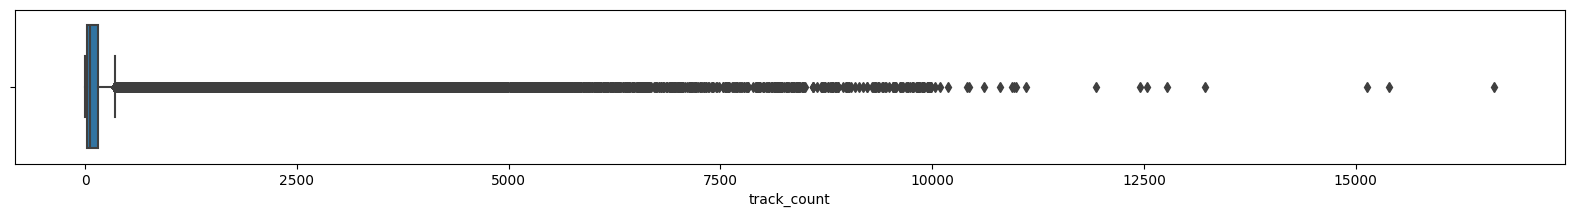

In [41]:
plt.figure(figsize=(20, 2))
sns.boxplot(df,x='track_count')

смотрим распределение пользователей по количеству прослушанных треков - большинство до 1000

<Axes: ylabel='Frequency'>

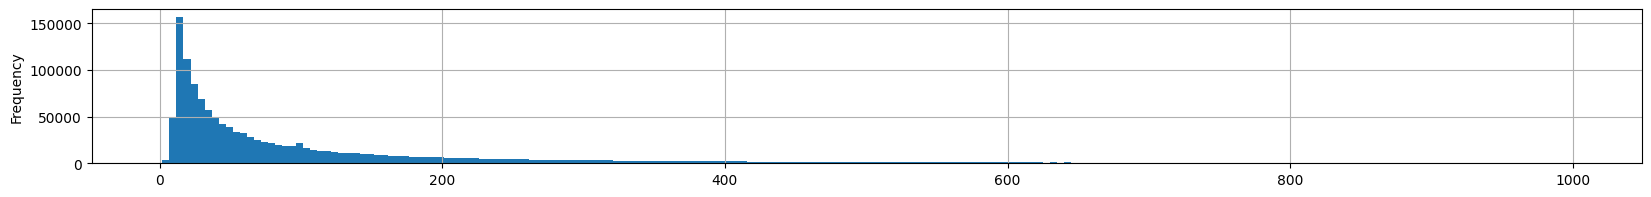

In [42]:
plt.figure(figsize=(20, 2))
df.query('track_count>1 and track_count<1000')['track_count'].plot(kind='hist',bins=200,grid=True)

посмотрим какую долю событий отсечем из-за выбросов
 - слишком активные пользователи (меломаны, поведение похоже на роботов)
 - единичные прослушивания (о холодных пользователях мы ничего не значем, по ним можно будет рекоммендовать наиболее популярные треки/похожие)

In [43]:
A=30
B=800

In [ ]:
user_low=df.query('track_count<@A')['track_count'].sum() #мусор - считаем холодными таких пользователей
user_high=df.query('track_count>@B')['track_count'].sum() #роботы - можно удалить
print(f"не активные пользователи - {user_low},роботы - {user_high},общая доля условно мусора- {round((user_low+user_high)/df['track_count'].sum(),2)}")

не активные пользователи - 8047117,роботы - 74590097,общая доля условно мусора- 0.37


фильтруем
 - кто слушает более 800 треков (сюда могут попадать роботы и специфический вкус) таким образом уменьшаем массив данных, проще будет делать расчеты
 - пользователей до 30 треков считаем холодными - они малоинформативны

<Axes: xlabel='track_count'>

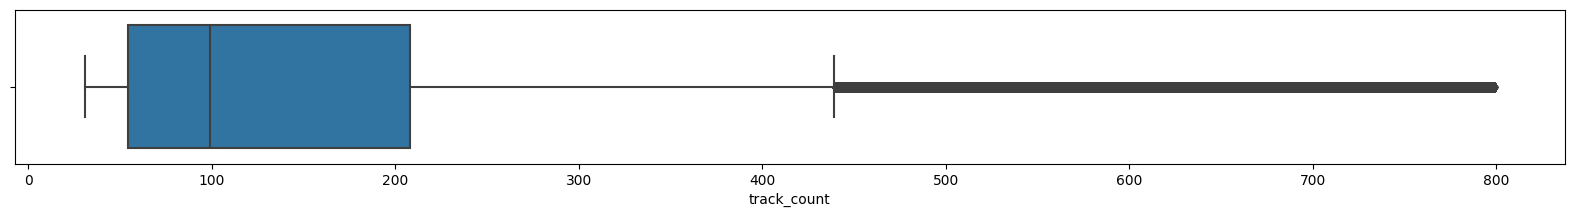

In [45]:
df_filter=df.query('track_count>@A and track_count<@B')

plt.figure(figsize=(20, 2))
sns.boxplot(df_filter,x='track_count')

In [46]:
df_filter['track_count'].sum()

139515984

Cократили значительно выборку

In [47]:
good_users=df_filter['user_id']

good_interactions=interactions.query('user_id in @good_users')
good_interactions

,user_id,track_id,track_seq,started_at,month,year,in_tracks
0,1,24417,1,2022-06-11,6,2022,True
1,1,108208,2,2022-06-13,6,2022,True
2,1,108209,3,2022-06-13,6,2022,True
3,1,592642,4,2022-06-15,6,2022,True
4,1,628687,5,2022-06-15,6,2022,True
...,...,...,...,...,...,...,...
287,1374582,95514767,288,2022-12-29,12,2022,True
288,1374582,97220301,289,2022-12-29,12,2022,True
289,1374582,97241171,290,2022-12-29,12,2022,True
290,1374582,98542641,291,2022-12-29,12,2022,True


Исследуем наиболее популярные треки - до и после очистки от массовых пользователей (роботов и меломанов)

In [48]:
tracks_count=interactions.groupby('track_id').agg({'user_id':'count'}).reset_index().rename(columns={'user_id':'user_count'}).sort_values(by='user_count',ascending=False)

In [49]:
tracks_count.head(3) #редкие треки слушают по 100000 раз

,track_id,user_count
9098,53404,111062
483876,33311009,106921
26665,178529,101924


In [50]:
tracks_count['user_count'].mean() #в среднем по 222 раза

222.629898

<Axes: ylabel='Frequency'>

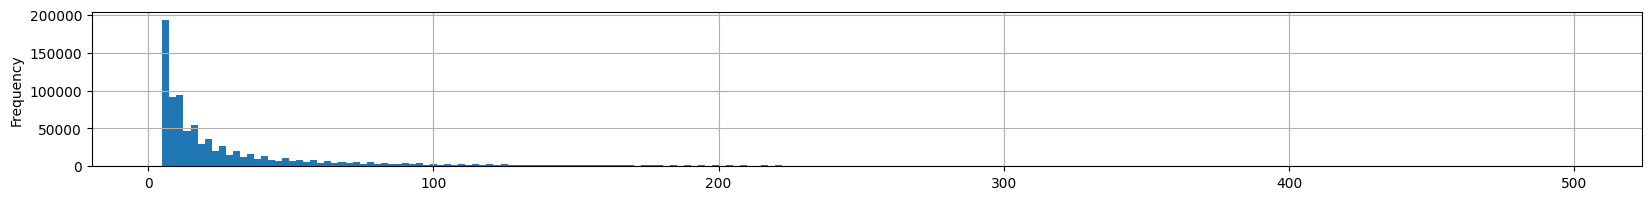

In [51]:
plt.figure(figsize=(20, 2))
tracks_count.query('user_count<500')['user_count'].plot(kind='hist',bins=200,grid=True)

Вывод - большинство треков слушают редко, сократим количество треков для исследования - уберем редкие треки и тем самым уменьшим размерность матрицы пользователь-трек

In [52]:
C=50

In [53]:
good_tracks=tracks_count.query('user_count>@C') #фильтруем треки, которые прослушали более Х раз

смотрим топ популярных треков

In [54]:
tracks_filter_count=(interactions#good_interactions
                   .groupby('track_id')
                   .agg({'user_id':'count'})
                   .reset_index()
                   .rename(columns={'user_id':'user_count'})
                   .sort_values(by='user_count',ascending=False)
                   .head(10)
                   .merge(track_cat,left_on='track_id',right_on='id',how='left')
                   .drop(columns=['id','type']))

tracks_filter_count

,track_id,user_count,name
0,53404,111062,Smells Like Teen Spirit
1,33311009,106921,Believer
2,178529,101924,Numb
3,35505245,99490,I Got Love
4,65851540,86670,Юность
5,24692821,86246,Way Down We Go
6,32947997,85886,Shape of You
7,51241318,85244,In The End
8,795836,85042,Shape Of My Heart
9,45499814,84748,Life


<Axes: xlabel='user_count', ylabel='name'>

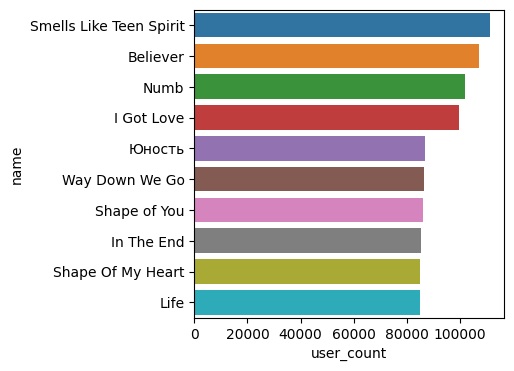

In [ ]:
plt.figure(figsize=(4, 4))
sns.barplot(data=tracks_filter_count, x='user_count', y='name')

смотрим теперь меняются ли предпочтения по периодам
возможно имеет место популярность треков (например кто-то популярен всегда, кто-то появляется и потом исчезает)

In [56]:
#готовим данные
pop_by_month=(interactions#good_interactions
              .groupby(['track_id','month'])
              .agg({'user_id':'count'})
              .reset_index()
              .sort_values(by=['month','user_id'],ascending=[True,False]))


смотрю на примере нескольких месяцев

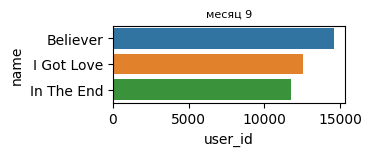

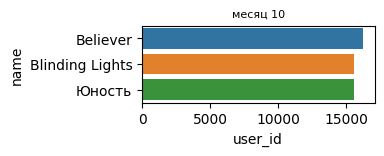

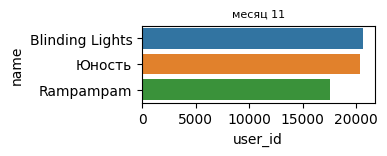

In [57]:
for i in range(9,12):
    a=pop_by_month.query('month==@i').head(3).merge(track_cat,left_on='track_id',right_on='id',how='left')
    plt.figure(figsize=(3, 1))
    sns.barplot(a, x='user_id', y='name')
    plt.title(f"месяц {i}",fontsize=8)
    plt.show()

Вывод - есть эффект хайпа - новые песни залетают в предпочтения - вывод - для рекомендаций скорее всего надо использовать инфо за 1 -2 месяца, более поздние будем считать старыми


Наиболее популярные жанры

In [58]:
test1_genre=(pop_by_month
             .query('month==1')
             #.head(3)
             .merge(tracks, on='track_id', how='left')
             .explode('genres')
             .groupby(['month','genres'])
             .agg({'track_id':'count'})
             .reset_index()
             .sort_values(by='track_id',ascending=False)
             .head(5)
             .merge(genre_cat,left_on='genres',right_on='id',how='left')
)
for i in range(2,13):
    test=(pop_by_month
             .query('month==@i')
             .merge(tracks, on='track_id', how='left')
             .explode('genres')
             .groupby(['month','genres'])
             .agg({'track_id':'count'})
             .reset_index()
             .sort_values(by='track_id',ascending=False)
             .head(5)
             .merge(genre_cat,left_on='genres',right_on='id',how='left')
    )
    test1_genre=pd.concat([test1_genre,test])


In [59]:
test1_genre['name'].unique()

array(['pop', 'allrock', 'rap', 'electronics', 'rock', 'metal', 'rusrap'],
      dtype=object)

Смотрим динамику по жанрам

Text(0, 0.5, 'Количество прослушиваний')

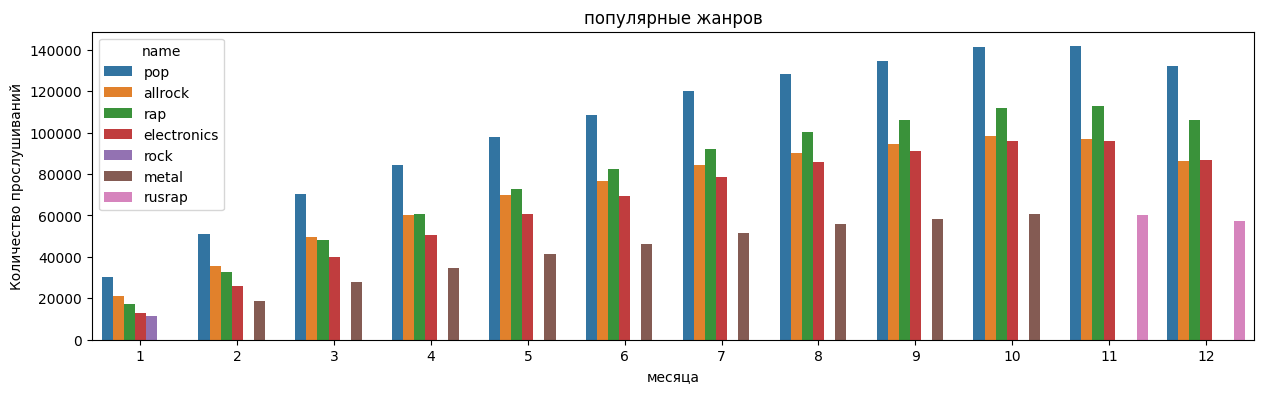

In [60]:
plt.figure(figsize=(15, 4))
sns.barplot(test1_genre, y='track_id', x='month',hue='name')
plt.title('популярные жанров')
plt.xlabel('месяца')
plt.ylabel('Количество прослушиваний')

Выводы
 - pop - самый популярный
 - rap - на 2 месте
 - 3 и 4 место - electronics обгоняет allrock
 - 5 место - rusrap

Треки, которые никто не прослушал

In [61]:
# получаем треки, которые не были прослушаны
unlistened_tracks = tracks[~tracks['track_id'].isin(interactions['track_id'])]
unlistened_tracks

,track_id,albums,artists,genres


In [62]:
stage3_EDA=time.time()

# выводы EDA
 - матрица U_I будет очень большой размерности
 - для экономии ресурсов можно вначале отфильтровать пользователей - убрать единичные прослушивание, похожих на роботов и все расчеты сделать только на части данных
 - также можно убрать треки с единичными прослушиваниями (добавим доп условие что для попадания в рекомендации трек должен быть прослушан хотя бы N раз) - это также уменьшит выборку
 - сервис в 22 году активно рос, наиболее популярные треки меняются с течением времени (для рекомендаций в конце года мало полезны популярные треки начала года)
 - популярность жанров также меняется со временем - например 3 и 4 место - electronics обгоняет allrock
 - в выборке представлены треки, прослушанные хотя бы 1 раз

Гипотезы - возможные признаки для генерации
- жанр трека чистый/смешанный
- исполнитель трека 1/несколько
- сколько месяцев пользователь присутствует на сервисе
- сколько треков пользователь прослушал
- популярность треков среди пользователей за несколько месяцев (т.к. по результатам EDA выяснили, что предпочтения меняются)

# Преобразование данных

Преобразуем данные в формат, более пригодный для дальнейшего использования в расчётах рекомендаций.

напомню что по результатам EDA принято решение фильтровать
 - треки (убирать редко прослушиваемые) good_tracks=tracks_count.query('user_count>@C')
 - пользователи (холодные и супер активные) good_interactions=interactions.query('user_id in @good_users')

# - таблица с треками

In [63]:
good_tracks_list=set(good_tracks['track_id'])

In [64]:
tracks_0=tracks.query('track_id in @good_tracks_list')

In [65]:
#tracks.query('track_id not in @good_tracks_list')

In [66]:
tracks_1=tracks_0.merge(track_cat,left_on='track_id',right_on='id',how='left')
tracks_1=tracks_1.drop(columns=['type','id'])

In [67]:
#преобразование в словарь

artists_names = artist_cat.set_index('id')['name'].to_dict()
albums_names = album_cat.set_index('id')['name'].to_dict()
genres_names = genre_cat.set_index('id')['name'].to_dict()

In [68]:
# лямбда для формирования кортежей с наименованиями на основе кортежей с ids
func_albums_names = lambda x: tuple(map(albums_names.__getitem__, x))
func_artists_names = lambda x: tuple(map(artists_names.__getitem__, x))
func_genres_names = lambda x: tuple(map(genres_names.__getitem__, x))

In [69]:
tracks_1['names_of_albums_'] = tracks_1['albums'].map(func_albums_names)
tracks_1['names_of_artists'] = tracks_1['artists'].map(func_artists_names)

In [70]:
no_catalog_genrelist #неизвестные жанры
#список треков с неизвестными жанрами
tracks_no_catalog_genrelist=tracks_1.explode('genres').query('genres in @no_catalog_genrelist')['track_id']
tracks_2=tracks_1.query('track_id not in @tracks_no_catalog_genrelist')


# - таблица с активностью пользователей

In [71]:
interactions_1=good_interactions # фильтруем по пользователям

In [72]:
tracks_filter=set(tracks_2['track_id'])

In [73]:
interactions_2=interactions_1.query('track_id in @tracks_filter') # фильтруем по трекам 

# - пробуем уменьшить вес таблиц

In [74]:
# проверка сколько ресурсов потребляет датафрем
def memory_load(df):
    memory_info = df.memory_usage(deep=True)
    total_memory = memory_info.sum()
    print("Память по столбцам:")
    print(memory_info)
    print("\nОбщее использование памяти (в байтах):", total_memory)

memory_load(interactions_2)

Память по столбцам:
Index         1039175472
user_id        519587736
track_id       519587736
track_seq      259793868
started_at    1039175472
month          519587736
year           519587736
in_tracks      129896934
dtype: int64

Общее использование памяти (в байтах): 4546392690


In [75]:
interactions_2 = interactions_2.reset_index(drop=True)
interactions_2['started_at'] = interactions_2['started_at'].astype('category')

memory_load(interactions_2)

Память по столбцам:
Index               128
user_id       519587736
track_id      519587736
track_seq     259793868
started_at    259805084
month         519587736
year          519587736
in_tracks     129896934
dtype: int64

Общее использование памяти (в байтах): 2727846958


In [76]:
# проверка сколько ресурсов потребляет датафрем
def memory_load(df):
    memory_info = df.memory_usage(deep=True)
    total_memory = memory_info.sum()
    print("Память по столбцам:")
    print(memory_info)
    print("\nОбщее использование памяти (в байтах):", total_memory)

memory_load(tracks_2)

Память по столбцам:
Index                2223152
track_id             2223152
albums              33347280
artists             33347280
genres              33347280
name                26194757
names_of_albums_    20650232
names_of_artists    16209632
dtype: int64

Общее использование памяти (в байтах): 167542765


отфильтруем пока те столбцы, которые планируем использовать (если что - вернемся к этому шагу)

In [77]:
tracks_2_filt=tracks_2.drop(columns=['albums','artists'])

In [78]:
memory_load(tracks_2_filt)

Память по столбцам:
Index                2223152
track_id             2223152
genres              33347280
name                26194757
names_of_albums_    20650232
names_of_artists    16209632
dtype: int64

Общее использование памяти (в байтах): 100848205


вывод - почти в 2 раза таблица с треками уменьшилась

# Сохранение данных

Сохраним данные в двух файлах в персональном S3-бакете по пути `recsys/data/`:
- `items.parquet` — все данные о музыкальных треках,
- `events.parquet` — все данные о взаимодействиях.

In [79]:
events = interactions_2.copy()

In [80]:
events.to_parquet('data/events.parquet')

In [81]:
items = tracks_2_filt.copy()

In [82]:
items.to_parquet('data/items.parquet')

In [83]:
stage4_save=time.time()

# Очистка памяти

Здесь, может понадобится очистка памяти для высвобождения ресурсов для выполнения кода ниже. 

Приведите соответствующие код, комментарии, например:
- код для удаление более ненужных переменных,
- комментарий, что следует перезапустить kernel, выполнить такие-то начальные секции и продолжить с этапа 3.

In [84]:
%whos DataFrame

Variable              Type         Data/Info
--------------------------------------------
a                     DataFrame       track_id  month  user_<...>9  track        Rampampam
album_cat             DataFrame                  id   type  <...>[658724 rows x 3 columns]
artist_cat            DataFrame                  id    type <...>[153581 rows x 3 columns]
catalog_names         DataFrame                    id   type<...>1812471 rows x 3 columns]
df                    DataFrame             user_id  track_c<...>1373221 rows x 2 columns]
df_filter             DataFrame             user_id  track_c<...>[860108 rows x 2 columns]
events                DataFrame               user_id   trac<...>9896934 rows x 7 columns]
genre_cat             DataFrame              id   type      <...>n\n[166 rows x 3 columns]
good_interactions     DataFrame         user_id   track_id  <...>9515984 rows x 7 columns]
good_tracks           DataFrame             track_id  user_c<...>[292025 rows x 2 columns]


на текущий момент очень много лишних объектов создано, чистим

In [85]:
del tracks, tracks_0, tracks_1, tracks_2_filt, tracks_count, tracks_filter_count, unlistened_tracks, good_tracks #tracks_2 - пока оставим
del interactions, interactions_1, interactions_2, good_interactions, events, 
del df, df_filter, a, album_cat,artist_cat, catalog_names
del genre_cat, items, pop_by_month, test, test1_genre, track_cat, tracks_2

In [86]:
%whos DataFrame

No variables match your requested type.


In [87]:
stage5_clean=time.time()

# === ЭТАП 3 ===

# Загрузка данных

Если необходимо, то загружаем items.parquet, events.parquet.

In [2]:
events_ = pd.read_parquet('data/events.parquet')

In [89]:
events_.head(5)

,user_id,track_id,track_seq,started_at,month,year,in_tracks
0,1,24417,1,2022-06-11,6,2022,True
1,1,108208,2,2022-06-13,6,2022,True
2,1,108209,3,2022-06-13,6,2022,True
3,1,592642,4,2022-06-15,6,2022,True
4,1,628687,5,2022-06-15,6,2022,True


In [3]:
items_=pd.read_parquet('data/items.parquet')

In [91]:
items_.head(5)

,track_id,genres,name,names_of_albums_,names_of_artists
0,141,[11],Never Forget You,"[Wild Young Hearts, Wild Young Hearts, I Am Wo...",[Noisettes]
1,146,"[59, 102]",I'm Goin' Mad,"[Lonesome Crow, Lonesome Crow]",[Scorpions]
2,148,"[59, 102]",It All Depends,"[Lonesome Crow, Gold, Lonesome Crow]",[Scorpions]
3,151,"[59, 102]",Inheritance,"[Lonesome Crow, Lonesome Crow, Krautrock]",[Scorpions]
4,353,[11],Sunny Mystery,[Foot Of The Mountain],[a-ha]


In [92]:
stage6_import=time.time()

# Разбиение данных

Разбиваем данные на тренировочную, тестовую выборки.

In [4]:
# зададим точку разбиения (сразу учтем что для модели ранжирования нужна будет доп разбивка для получения таргетов)
#пробую сделать разбивку с 01.12 по 15.12 и с 15.12 по 31.12. качество измеряю с 15 по 31.12
train_test_global_time_split_date = pd.to_datetime('2022-12-01')#('2022-12-20')
train_test_global_time_split_idx = events_["started_at"] < train_test_global_time_split_date
for_test=events_["started_at"] > pd.to_datetime('2022-12-15')
for_catboost=(train_test_global_time_split_date<=events_["started_at"])&(events_["started_at"] <= pd.to_datetime('2022-12-15'))

events_train = events_[train_test_global_time_split_idx]
events_catboost=events_[for_catboost]
events_test = events_[for_test]

In [94]:
#проверяю даты
#events_train['started_at'].min()

количество пользователей

In [5]:
# в train и test
users_train = events_train["user_id"].drop_duplicates()
users_test = events_test["user_id"].drop_duplicates()
users_catboost = events_catboost["user_id"].drop_duplicates()

# количество пользователей, которые есть и в train, и в test
common_users = events_["user_id"].drop_duplicates()

print(len(users_train), len(users_test), len(common_users),len(users_catboost)) 

818450 483885 859810 597998


In [6]:
#делаю датафреймы с тест/train и всеми пользователями

pd_users_test=pd.DataFrame(users_test)
pd_users_test['name']='test'

pd_users_train=pd.DataFrame(users_train)
pd_users_train['name_train']='train'

pd_common_users=pd.DataFrame(common_users)
pd_common_users['all']='all'

pd_users_catboost=pd.DataFrame(users_train)
pd_users_catboost['name_cat']='catboost'

для наглядности общая таблица пользователей с пометками наличия в тренировочной/тестовой выборке - USER

In [7]:
#получились холодные пользователм
USERS = pd_common_users.set_index('user_id').join([pd_users_test.set_index('user_id'),pd_users_train.set_index('user_id'),pd_users_catboost.set_index('user_id')],how='left').reset_index().fillna(0)
USERS.query('name=="test" and name_train!="train"').count()

user_id       41107
all           41107
name          41107
name_train    41107
name_cat      41107
dtype: int64

можем посчитать долю пользователей, которые попали в обе выборки от общей выборки тестовой

In [8]:
both_users=len(USERS.query('name=="test" and name_train=="train"'))

print(f"пользователи в 2х выборках - {both_users}, что составляет {round(both_users/len(users_test),3)} от общих пользователей теста")

пользователи в 2х выборках - 442778, что составляет 0.915 от общих пользователей теста


посчитаем количество "холодных" пользователей

In [9]:
cold_users_=USERS.query('name!=0 and name_train==0')['user_id']
len(cold_users_)

41107

Вывод - в целом хорошее получилось разделение, 90% общих пользователей, холодных пользователей 10%, событий train ~в 2 раза больше, чем в тесте

In [100]:
stage7_split=time.time()

# Топ популярных

Рассчитаем рекомендации как топ популярных.

In [101]:
item_popularity = events_train.groupby('track_id').agg(track_count=("user_id","count")).reset_index().sort_values(by='track_count',ascending=False)
item_popularity.head(5)

,track_id,track_count
3350,53404,79594
9177,178529,72976
129285,33311009,68590
137329,35505245,68458
27795,795836,59153


Нормализация

In [102]:
x_min=item_popularity['track_count'].min()
x_max=item_popularity['track_count'].max()
item_popularity['score']=round(item_popularity['track_count'].apply(lambda x: (x-x_min)/(x_max-x_min)),2)
top_k_pop_items=item_popularity[["track_id","score"]].head(5) #остановимся на 5 лучших (чтобы не получать очевидных рекоммендаций)
top_k_pop_items

,track_id,score
3350,53404,1.00
9177,178529,0.92
129285,33311009,0.86
137329,35505245,0.86
27795,795836,0.74


Популярные треки с названиями

In [103]:
top_k_pop_items_names=top_k_pop_items.merge(items_,on='track_id',how='left')[['track_id','score','name']]
top_k_pop_items_names

,track_id,score,name
0,53404,1.00,Smells Like Teen Spirit
1,178529,0.92,Numb
2,33311009,0.86,Believer
3,35505245,0.86,I Got Love
4,795836,0.74,Shape Of My Heart


Получили рекомендации по умолчанию - default recommendations

оценим их качество - соотнесем с событиями из теста

In [104]:
cold_users_with_recs=events_test[events_test["user_id"].isin(cold_users_)].merge(top_k_pop_items_names,on='track_id',how='left')

cold_users_with_recs_len=cold_users_with_recs['user_id'].nunique()
cold_users_with_recs_positive_len=len(cold_users_with_recs.query('score>0'))
print(f"доля пользователей использующих default rec - {cold_users_with_recs_positive_len/cold_users_with_recs_len}")

доля пользователей использующих default rec - 0.14214124115114213


25 % пользователей - для старта хороший показатель
 - вывод - треки из top_k_pop достаточно популярны
 - Такие рекомендации полезны, но их нельзя назвать персональными

In [105]:
top_k_pop_items_names.to_parquet('recs/top_k_pop_items_names.parquet')

In [106]:
recom_top = (
    events_test[['user_id']]
    .drop_duplicates()
    .reset_index(drop=True)
    .merge(top_k_pop_items_names, how='cross')
    .reset_index(drop=True)
)[['user_id','track_id','score']]
recom_top.head(5)

,user_id,track_id,score
0,3,53404,1.00
1,3,178529,0.92
2,3,33311009,0.86
3,3,35505245,0.86
4,3,795836,0.74


Сохраняем локально

In [107]:
recom_top.to_parquet("recs/top_popular.parquet")

In [108]:
stage8_pop=time.time()

# Персональные

Рассчитаем персональные рекомендации.

Для начала оценим разреженность оценок

In [109]:
a=events_train['user_id'].nunique()
b=events_train['track_id'].nunique()
c=len(events_train)
c/(a*b)*100
#всего вариантов a*b
#значений в U-I матрице заполнено, матрица сильно разрежена

0.04791488246902202

5% матрицы пользователь - трек заполнено

перекодируем идентификаторы пользователей из имеющихся в последовательность 0, 1, 2, ...

In [111]:
user_encoder = sklearn.preprocessing.LabelEncoder()
user_encoder.fit(events_["user_id"])
events_train["user_id_enc"] = user_encoder.transform(events_train["user_id"])

перекодируем идентификаторы объектов из имеющихся в последовательность 0, 1, 2, ...

In [112]:
item_encoder = sklearn.preprocessing.LabelEncoder()
item_encoder.fit(items_["track_id"])
items_["track_id_enc"] = item_encoder.transform(items_["track_id"])
events_train["track_id_enc"] = item_encoder.transform(events_train["track_id"])

создаём sparse-матрицу формата CSR 

In [113]:
user_item_matrix_train = scipy.sparse.csr_matrix((
    np.ones(len(events_train)),
    (events_train['user_id_enc'], events_train['track_id_enc'])),
    dtype=np.int8)

user_item_matrix_train #матрица пользователь треки

<Compressed Sparse Row sparse matrix of dtype 'int8'
	with 108976379 stored elements and shape (859810, 277894)>

In [114]:
#получим рейтинги на основе коллаборативных фильтраций на основе ALS
als_model = AlternatingLeastSquares(factors=40, iterations=10, regularization=0.05, random_state=0)
als_model.fit(user_item_matrix_train)

100%|██████████| 10/10 [03:25<00:00, 20.50s/it]


In [115]:
with open('models/als_model.pkl', 'wb') as f:
       pickle.dump(als_model, f)

In [116]:
with open('models/als_model.pkl', 'rb') as f:
    als_model = pickle.load(f)

Чтобы получить рекомендации для пользователя с помощью модели ALS, использую такую функцию:

In [117]:
def get_recommendations_als(user_item_matrix, model, user_id, user_encoder, item_encoder, include_seen=True, n=5):
    """
    Возвращает отранжированные рекомендации для заданного пользователя
    """
    user_id_enc = user_encoder.transform([user_id])[0]
    recommendations = model.recommend(
         user_id_enc, 
         user_item_matrix[user_id_enc], 
         filter_already_liked_items=not include_seen,
         N=n)
    recommendations = pd.DataFrame({"item_id_enc": recommendations[0], "score": recommendations[1]})
    recommendations["item_id"] = item_encoder.inverse_transform(recommendations["item_id_enc"])
    
    return recommendations

смотрим пример рекоммендаций (выберем случайного пользователя, который есть в обеих выборках train и test)

In [118]:
both_=USERS.query('name=="test" and name_train=="train"').reset_index()['user_id']
user_id_example=events_train.query('user_id in @both_')['user_id'].sample().iat[0]
user_id_example

1076955

используя обученную модель, получим рекомендации для пользователя

In [119]:
als_test_user=get_recommendations_als(user_item_matrix_train, als_model, user_id_example, user_encoder, item_encoder)
als_test_user

,item_id_enc,score,item_id
0,137329,0.440569,35505245
1,217142,0.387878,61565558
2,207217,0.363691,57921154
3,208985,0.353832,58515506
4,194009,0.347190,52380688


смотрю информацию по трекам из рекоммендаций

In [120]:
als_test_user_track=als_test_user.merge(items_,left_on='item_id',right_on='track_id',how='left')
als_test_user_track['result']=1

als_test_user_track

,item_id_enc,score,item_id,track_id,genres,name,names_of_albums_,names_of_artists,track_id_enc,result
0,137329,0.440569,35505245,35505245,"[3, 75]",I Got Love,"[I Got Love, I Got Love]","[Miyagi & Эндшпиль, Рем Дигга]",137329,1
1,217142,0.387878,61565558,61565558,"[11, 20]",Луна не знает пути,"[Луна не знает пути, СОЮЗ 63]","[Тайпан, Agunda]",217142,1
2,207217,0.363691,57921154,57921154,"[11, 20]",Комета,[Комета],[JONY],207217,1
3,208985,0.353832,58515506,58515506,"[11, 20]",Увезите меня на Дип-хаус,[Увезите меня на Дип-хаус],[GAYAZOV$ BROTHER$],208985,1
4,194009,0.347190,52380688,52380688,"[11, 20]",Любимка,[Любимка],[NILETTO],194009,1


см фактические результаты у пользователя и есть ли пересечение

In [121]:
events_test.query('user_id==@user_id_example').merge(items_,on='track_id',how='left').merge(als_test_user_track,on='track_id',how='left')

,user_id,track_id,track_seq,started_at,month,year,in_tracks,genres_x,name_x,names_of_albums__x,...,track_id_enc_x,item_id_enc,score,item_id,genres_y,name_y,names_of_albums__y,names_of_artists_y,track_id_enc_y,result
0,1076955,84233822,172,2022-12-17,12,2022,True,[68],I WANT YOU BACK,"[I WANT YOU BACK, I Want You Back]",...,262935,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1076955,84311070,173,2022-12-17,12,2022,True,[16],WOAH,[WOAH],...,263019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1076955,84382282,174,2022-12-17,12,2022,True,"[3, 75]",Я в моменте,[Я в моменте],...,263078,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1076955,85335132,175,2022-12-18,12,2022,True,[75],スピードデーモン,"[スピードデーモン, love, phonk, why z music]",...,264260,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1076955,87563076,176,2022-12-18,12,2022,True,[16],Babel,[Babel],...,266888,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1076955,88266399,177,2022-12-21,12,2022,True,[16],Laparisa,[Laparisa],...,267623,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1076955,90014040,178,2022-12-22,12,2022,True,[16],Smack That,[Smack That],...,269649,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1076955,92868153,179,2022-12-25,12,2022,True,[68],Mark,[Mark],...,272666,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1076955,94324100,180,2022-12-27,12,2022,True,"[3, 75]",КТО УБИЛ МАРКА?,[КТО УБИЛ МАРКА?],...,274045,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1076955,99240797,181,2022-12-27,12,2022,True,[16],BOSSHEE,[BOSSHEE],...,277292,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


для случайного пользователя (user_id=997358) пересечений рекоммендаций и фактических результатов нет

Теперь получим рекомендации для всех имеющихся пользователей

In [122]:
user_ids_encoded = range(len(user_encoder.classes_))
user_ids_encoded

# получаем рекомендации для всех пользователей
als_recommendations = als_model.recommend(
    user_ids_encoded, 
    user_item_matrix_train[user_ids_encoded], 
    filter_already_liked_items=False, N=4) 

als_recommendations

(array([[145053, 188826, 123611, 188798],
        [137329, 129285, 176882, 186587],
        [ 24689,  22026,  24192,  77153],
        ...,
        [176882, 137329, 186587, 157087],
        [228482, 194009, 127079, 186587],
        [176882, 157087, 186587, 200371]], dtype=int32),
 array([[0.05626827, 0.04551451, 0.0434157 , 0.03572066],
        [0.53511906, 0.35273358, 0.32452694, 0.27750087],
        [0.2768026 , 0.23244675, 0.23096554, 0.22425196],
        ...,
        [1.0620899 , 0.947143  , 0.8916291 , 0.8752255 ],
        [0.82311225, 0.7699116 , 0.69961274, 0.6570257 ],
        [0.2220709 , 0.20153174, 0.18685158, 0.16543539]], dtype=float32))

преобразуем в удобный формат

In [123]:
# преобразуем полученные рекомендации в табличный формат
item_ids_enc = als_recommendations[0]
als_scores = als_recommendations[1]

als_recommendations = pd.DataFrame({
    "user_id_enc": user_ids_encoded,
    "item_id_enc": item_ids_enc.tolist(), 
    "score": als_scores.tolist()})
als_recommendations = als_recommendations.explode(["item_id_enc", "score"], ignore_index=True)

# приводим типы данных
als_recommendations["item_id_enc"] = als_recommendations["item_id_enc"].astype("int")
als_recommendations["score"] = als_recommendations["score"].astype("float")

# получаем изначальные идентификаторы
als_recommendations["user_id"] = user_encoder.inverse_transform(als_recommendations["user_id_enc"])
als_recommendations["item_id"] = item_encoder.inverse_transform(als_recommendations["item_id_enc"])
als_recommendations = als_recommendations.drop(columns=["user_id_enc", "item_id_enc"])

als_recommendations=als_recommendations.rename(columns={'item_id':'track_id'})
als_recommendations

,score,user_id,track_id
0,0.056268,1,37258117
1,0.045515,1,50685843
2,0.043416,1,32291816
3,0.035721,1,50684233
4,0.535119,3,35505245
...,...,...,...
3439235,0.657026,1374581,49961817
3439236,0.222071,1374582,45499814
3439237,0.201532,1374582,39946957
3439238,0.186852,1374582,49961817


для расчета метрик закодирую тест

In [124]:
events_test["user_id_enc"] = user_encoder.transform(events_test["user_id"])
events_test["track_id_enc"] = item_encoder.transform(events_test["track_id"])

сохраним рекомендации

In [125]:
als_recommendations.to_parquet("recs/personal_als.parquet")

In [126]:
stage9_ALS=time.time()

# Похожие

Рассчитаем похожие, они позже пригодятся для онлайн-рекомендаций.

In [127]:
# получим энкодированные идентификаторы всех объектов, известных нам из events_train
train_item_ids_enc = events_train['track_id_enc'].unique()
train_item_ids_enc

array([  1728,   6452,   6453, ..., 272130, 225732, 235773])

получаем списки похожих объектов, используя ранее полученную ALS-модель
 - метод similar_items возвращает и сам объект, как наиболее похожий

In [128]:
max_similar_items = 4

similar_items = als_model.similar_items(train_item_ids_enc, N=max_similar_items+1)

преобразуем полученные списки в табличный формат

In [129]:
sim_item_item_ids_enc = similar_items[0]
sim_item_scores = similar_items[1]

similar_items = pd.DataFrame({
    "track_id_enc": train_item_ids_enc,
    "sim_track_id_enc": sim_item_item_ids_enc.tolist(), 
    "score": sim_item_scores.tolist()})
similar_items = similar_items.explode(["sim_track_id_enc", "score"], ignore_index=True)

преобразуем в удобный формат

In [130]:
# приводим типы данных
similar_items["sim_track_id_enc"] = similar_items["sim_track_id_enc"].astype("int")
similar_items["score"] = similar_items["score"].astype("float")

# получаем изначальные идентификаторы
similar_items["track_id_1"] = item_encoder.inverse_transform(similar_items["track_id_enc"])
similar_items["track_id_2"] = item_encoder.inverse_transform(similar_items["sim_track_id_enc"])
similar_items = similar_items.drop(columns=["track_id_enc", "sim_track_id_enc"])

# убираем пары с одинаковыми объектами
similar_items = similar_items.query("track_id_1 != track_id_2")

смотрю на примерах - действительно похожие рекомендации по жанрам, исполнителям

In [131]:
track_names_=items_[['track_id','name','names_of_artists','names_of_albums_']]

In [132]:
similar_items.head(4).merge(track_names_,left_on='track_id_1',right_on='track_id',how='left').merge(track_names_,left_on='track_id_2',right_on='track_id',how='left')

,score,track_id_1,track_id_2,track_id_x,name_x,names_of_artists_x,names_of_albums__x,track_id_y,name_y,names_of_artists_y,names_of_albums__y
0,0.987385,24417,43130,24417,Du Riechst So Gut,[Rammstein],[Herzeleid. XXV Anniversary Edition],43130,Links 2 3 4,[Rammstein],"[Mutter, Mutter, Mutter, SPORT FREI]"
1,0.982825,24417,43127,24417,Du Riechst So Gut,[Rammstein],[Herzeleid. XXV Anniversary Edition],43127,Ich Will,[Rammstein],"[Mutter, Mutter, Mutter, SPORT FREI]"
2,0.981918,24417,55568,24417,Du Riechst So Gut,[Rammstein],[Herzeleid. XXV Anniversary Edition],55568,"Reise, Reise",[Rammstein],"[Reise, Reise, Reise, Reise]"
3,0.981063,24417,24413,24417,Du Riechst So Gut,[Rammstein],[Herzeleid. XXV Anniversary Edition],24413,Asche zu Asche,[Rammstein],[Herzeleid. XXV Anniversary Edition]


Несколько очевидная рекомендация по аналогичному исполнителю

In [133]:
similar_items.to_parquet("recs/similar.parquet") 

In [134]:
stage10_similar=time.time()

# Ранжирование рекомендаций

Построим ранжирующую модель, чтобы сделать рекомендации более точными. Отранжируем рекомендации.

 - 1 сначала обработаю полученные ранее расчеты
 - 2 затем делаю расчет для периода train+catboost
 - 3 делаю расчет с учетом новых данных из периода catboost

# === часть 1 - расчет для events_train ===

возьмем рассчитанные ранее рекомендации из train

In [5]:
popularity_recommendations=pd.read_parquet("recs/top_popular.parquet")
als_recommendations=pd.read_parquet("recs/personal_als.parquet")

In [6]:
candidates = pd.merge(
    als_recommendations[["user_id", "track_id", "score"]].rename(columns={"score": "als_score"}),
    popularity_recommendations[["user_id", "track_id", "score"]].rename(columns={"score": "pop_score"}),
    on=['user_id','track_id'],
    how="outer").fillna(0)

In [ ]:
print(f"доля совпадений в рекомендациях - {round(len(candidates.query('als_score!=0 and pop_score!=0'))/len(candidates),3)}")

доля совпадений в рекомендациях - 0.035


3% треков с ненулевым скором от всех рекоммендаций 2х методов

добавляем таргет к кандидатам со значением:
 — 1 для тех item_id, которые пользователь прочитал
 — 0, для всех остальных 

In [8]:
events_catboost["target"] = 1

candidates = candidates.merge(events_catboost[["user_id", "track_id", "target"]], on=['user_id','track_id'],how='left').fillna(0)
candidates

,user_id,track_id,als_score,pop_score,target
0,1,37258117,0.056268,0.00,0.0
1,1,50685843,0.045515,0.00,0.0
2,1,32291816,0.043416,0.00,0.0
3,1,50684233,0.035721,0.00,0.0
4,3,35505245,0.535119,0.86,0.0
...,...,...,...,...,...
5661111,1374582,53404,0.000000,1.00,0.0
5661112,1374582,178529,0.000000,0.92,0.0
5661113,1374582,33311009,0.000000,0.86,0.0
5661114,1374582,35505245,0.000000,0.86,0.0


см какая доля наблюдений получилась с таргетом 1

In [9]:
candidates.groupby('target')['user_id'].count()

target
0.0    5630584
1.0      30532
Name: user_id, dtype: int64

надо балансировать классы

в кандидатах оставляем только тех пользователей, у которых есть хотя бы 1 положительный таргет

In [10]:
candidates_to_sample = candidates.groupby("user_id").filter(lambda x: x["target"].sum() > 0)
candidates_to_sample

,user_id,track_id,als_score,pop_score,target
12,5,53404,0.427146,1.00,0.0
13,5,37384,0.370207,0.00,0.0
14,5,148345,0.341203,0.00,0.0
15,5,178529,0.328936,0.92,0.0
336,138,65851540,0.162286,0.00,0.0
...,...,...,...,...,...
5661096,1374573,53404,0.000000,1.00,0.0
5661097,1374573,178529,0.000000,0.92,0.0
5661098,1374573,33311009,0.000000,0.86,0.0
5661099,1374573,35505245,0.000000,0.86,0.0


см какая доля наблюдений получилась с таргетом 1

In [11]:
candidates_to_sample.groupby('target')['user_id'].count()

target
0.0    190318
1.0     30532
Name: user_id, dtype: int64

стало лучше, продолжим

In [12]:
candidates_to_sample.loc[candidates_to_sample['target']==0,'target_negative']=1
candidates_to_sample=candidates_to_sample.fillna(0)

в кандидатах оставляем только тех пользователей, у которых есть хотя бы 4 отрицательных таргета

In [13]:
candidates_to_sample = candidates_to_sample.groupby("user_id").filter(lambda x: x["target_negative"].sum() >= 4)
candidates_to_sample

,user_id,track_id,als_score,pop_score,target,target_negative
12,5,53404,0.427146,1.00,0.0,1.0
13,5,37384,0.370207,0.00,0.0,1.0
14,5,148345,0.341203,0.00,0.0,1.0
15,5,178529,0.328936,0.92,0.0,1.0
336,138,65851540,0.162286,0.00,0.0,1.0
...,...,...,...,...,...,...
5661096,1374573,53404,0.000000,1.00,0.0,1.0
5661097,1374573,178529,0.000000,0.92,0.0,1.0
5661098,1374573,33311009,0.000000,0.86,0.0,1.0
5661099,1374573,35505245,0.000000,0.86,0.0,1.0


см какая доля наблюдений получилась с таргетом 1

In [14]:
candidates_to_sample.groupby('target')['user_id'].count()

target
0.0    187404
1.0     29448
Name: user_id, dtype: int64

In [ ]:
candidates_to_sample.query('target==0').groupby('user_id').agg({'track_id':'count'}).reset_index().sort_values(by='track_id').head(3)

,user_id,track_id
24382,1330405,4
12568,680686,4
12651,685752,4


смотрим пример пользователя

In [16]:
candidates_to_sample[candidates_to_sample['user_id']==candidates_to_sample['user_id'].sample().iat[0]]

,user_id,track_id,als_score,pop_score,target,target_negative
242176,96983,3703085,0.273109,0.00,0.0,1.0
242177,96983,23559960,0.253887,0.00,0.0,1.0
242178,96983,19152669,0.249929,0.00,0.0,1.0
242179,96983,17079396,0.238618,0.00,0.0,1.0
3596149,96983,53404,0.000000,1.00,0.0,1.0
3596150,96983,178529,0.000000,0.92,0.0,1.0
3596151,96983,33311009,0.000000,0.86,1.0,0.0
3596152,96983,35505245,0.000000,0.86,0.0,1.0
3596153,96983,795836,0.000000,0.74,0.0,1.0


Обучим модель ранжирования

In [17]:
# задаём имена колонок признаков и таргета
features = ['als_score', 'pop_score']
target = 'target'


# создаём Pool
train_data = Pool(
    data=candidates_to_sample[features], 
    label=candidates_to_sample[target])

# инициализируем модель CatBoostClassifier
cb_model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    loss_function='Logloss',
    verbose=100,
    random_seed=0,
)

# тренируем модель
cb_model.fit(train_data)

# Посмотрим на важность признаков построенной модели
pd.DataFrame(
    cb_model.get_feature_importance(), 
    index=features, 
    columns=['feature_importance']
).sort_values(by='feature_importance', ascending=False)


0:	learn: 0.6108839	total: 130ms	remaining: 1m 4s
100:	learn: 0.3653285	total: 2.56s	remaining: 10.1s
200:	learn: 0.3647530	total: 5.77s	remaining: 8.58s
300:	learn: 0.3643892	total: 8.28s	remaining: 5.47s
400:	learn: 0.3641383	total: 10.6s	remaining: 2.61s
499:	learn: 0.3639332	total: 12.7s	remaining: 0us


,feature_importance
pop_score,75.067923
als_score,24.932077


сохраним модель

In [18]:
with open('models/cb_model.pkl', 'wb') as f:
       pickle.dump(cb_model, f)

In [19]:
with open('models/cb_model.pkl', 'rb') as f:
    cb_model = pickle.load(f)

In [26]:
stage11_catboost_base=time.time()

# === часть 2.1 - прошло время - топ популярных ===

обернем в функцию, чтобы можно было переиспользовать многократно

In [20]:
def popularity_score(df,df_rec,k):
    #сортировка треков
    item_popularity = df.groupby('track_id').agg(track_count=("user_id","count")).reset_index().sort_values(by='track_count',ascending=False)
    #нормализация
    x_min=item_popularity['track_count'].min()
    x_max=item_popularity['track_count'].max()
    item_popularity['score']=item_popularity['track_count'].apply(lambda x: (x-x_min)/(x_max-x_min))
    top_k_pop_items=item_popularity[["track_id","score"]].head(k)
    top_k_pop_items_names=top_k_pop_items.merge(items_,on='track_id',how='left')[['track_id','score','name']]
    recom_top = (
    df[['user_id']]
    .drop_duplicates()
    .reset_index(drop=True)
    .merge(top_k_pop_items_names, how='cross')
    .reset_index(drop=True))

    return recom_top

In [30]:
events_train2=pd.concat([events_train,events_catboost])

Обновленные рекоммендации

In [22]:
recom_top_2=popularity_score(events_train2,events_test,5)
recom_top_2

,user_id,track_id,score,name
0,1,53404,1.000000,Smells Like Teen Spirit
1,1,178529,0.919056,Numb
2,1,33311009,0.918615,Believer
3,1,35505245,0.896165,I Got Love
4,1,24692821,0.761038,Way Down We Go
...,...,...,...,...
4233235,1374535,53404,1.000000,Smells Like Teen Spirit
4233236,1374535,178529,0.919056,Numb
4233237,1374535,33311009,0.918615,Believer
4233238,1374535,35505245,0.896165,I Got Love


сохраняем

In [23]:
recom_top_2.to_parquet("recs/top_popular_2.parquet")

In [24]:
stage12_for_catboost_pop=time.time()

# === часть 2.2 - прошло время - персональные ===

In [25]:
# перекодируем идентификаторы пользователей: 
# из имеющихся в последовательность 0, 1, 2, ...
user_encoder = sklearn.preprocessing.LabelEncoder()
user_encoder.fit(events_["user_id"])
events_train2["user_id_enc"] = user_encoder.transform(events_train2["user_id"])

In [26]:
# перекодируем идентификаторы объектов: 
# из имеющихся в последовательность 0, 1, 2, ...
item_encoder = sklearn.preprocessing.LabelEncoder()
item_encoder.fit(items_["track_id"])
items_["track_id_enc"] = item_encoder.transform(items_["track_id"])
events_train2["track_id_enc"] = item_encoder.transform(events_train2["track_id"])

In [27]:
# создаём sparse-матрицу формата CSR 
user_item_matrix_train = scipy.sparse.csr_matrix((
    np.ones(len(events_train2)),
    (events_train2['user_id_enc'], events_train2['track_id_enc'])),
    dtype=np.int8)

user_item_matrix_train #матрица пользователь треки

<Compressed Sparse Row sparse matrix of dtype 'int8'
	with 120586413 stored elements and shape (859810, 277894)>

In [34]:
#получим рейтинги на основе коллаборативных фильтраций на основе ALS
als_model_catboost = AlternatingLeastSquares(factors=50, iterations=10, regularization=0.05, random_state=0)
als_model_catboost.fit(user_item_matrix_train) 

100%|██████████| 10/10 [04:58<00:00, 29.83s/it]


In [35]:
with open('models/als_model_catboost.pkl', 'wb') as f:
       pickle.dump(als_model_catboost, f)

In [36]:
with open('models/als_model_catboost.pkl', 'rb') as f:
    als_model_catboost = pickle.load(f)

In [37]:
#Получим рекомендации для всех имеющихся пользователей
user_ids_encoded = range(len(user_encoder.classes_))
user_ids_encoded

# получаем рекомендации для всех пользователей
als_recommendations = als_model_catboost.recommend(
    user_ids_encoded, 
    user_item_matrix_train[user_ids_encoded], 
    filter_already_liked_items=False, N=5) 

als_recommendations


(array([[145053, 123611, 188826, 156065, 180915],
        [137329, 176882, 129285, 186587, 200371],
        [ 24689,  77153,  22026,  24192,  33079],
        ...,
        [176882, 157087, 137329, 186587, 200371],
        [194009, 228482, 245620, 127079, 260225],
        [236133, 176882, 200371, 232008, 157087]], dtype=int32),
 array([[0.06988708, 0.05462794, 0.03862946, 0.0367821 , 0.03508788],
        [0.5196024 , 0.36777923, 0.33599138, 0.3090555 , 0.293888  ],
        [0.28119165, 0.24771754, 0.24100915, 0.23371777, 0.20645238],
        ...,
        [1.2095659 , 0.9872819 , 0.9290532 , 0.92116743, 0.7023651 ],
        [0.86659646, 0.8425016 , 0.7672883 , 0.7057351 , 0.6781691 ],
        [0.30916846, 0.27507672, 0.24792488, 0.24782163, 0.2307976 ]],
       dtype=float32))

In [38]:
# преобразуем полученные рекомендации в табличный формат
item_ids_enc = als_recommendations[0]
als_scores = als_recommendations[1]

als_recommendations = pd.DataFrame({
    "user_id_enc": user_ids_encoded,
    "item_id_enc": item_ids_enc.tolist(), 
    "score": als_scores.tolist()})
als_recommendations = als_recommendations.explode(["item_id_enc", "score"], ignore_index=True)

# приводим типы данных
als_recommendations["item_id_enc"] = als_recommendations["item_id_enc"].astype("int")
als_recommendations["score"] = als_recommendations["score"].astype("float")

# получаем изначальные идентификаторы
als_recommendations["user_id"] = user_encoder.inverse_transform(als_recommendations["user_id_enc"])
als_recommendations["item_id"] = item_encoder.inverse_transform(als_recommendations["item_id_enc"])
als_recommendations = als_recommendations.drop(columns=["user_id_enc", "item_id_enc"])

In [39]:
als_recommendations=als_recommendations.rename(columns={'item_id':'track_id'})
als_recommendations

,score,user_id,track_id
0,0.069887,1,37258117
1,0.054628,1,32291816
2,0.038629,1,50685843
3,0.036782,1,39632975
4,0.035088,1,47026428
...,...,...,...
4299045,0.309168,1374582,69459326
4299046,0.275077,1374582,45499814
4299047,0.247925,1374582,54798445
4299048,0.247822,1374582,67538121


In [40]:
#сохраним рекомендации
als_recommendations.to_parquet("recs/personal_als_2.parquet")

In [46]:
stage13_for_catboost_pers=time.time()

# === часть 3 - объединение и расчет рекоммендаций catboost ===

In [16]:
#рекомендации для catboost
popularity_recommendations_2 = pd.read_parquet("recs/top_popular_2.parquet") 
als_recommendations_2 = pd.read_parquet("recs/personal_als_2.parquet") 

In [17]:
candidates_to_rank = pd.merge(
    als_recommendations_2[["user_id", "track_id", "score"]].rename(columns={"score": "als_score"}),
    popularity_recommendations_2[["user_id", "track_id", "score"]].rename(columns={"score": "pop_score"}),
    on=['user_id','track_id'],
    how="outer").fillna(0)

In [18]:
# оставляем только тех пользователей, что есть в тестовой выборке, для экономии ресурсов
candidates_to_rank = candidates_to_rank[candidates_to_rank["user_id"].isin(events_test["user_id"].drop_duplicates())]
print(len(candidates_to_rank)) 

4568283


In [44]:
inference_data = Pool(data=candidates_to_rank[features])
predictions = cb_model.predict_proba(inference_data)

candidates_to_rank["cb_score"] = predictions[:, 1]

candidates_to_rank = candidates_to_rank.sort_values(["user_id", "cb_score"], ascending=[True, False])

In [45]:
final_recommendations=candidates_to_rank.groupby('user_id').head(3).round(2)

final_recommendations=final_recommendations[['user_id', 'track_id', 'cb_score']].rename(columns={'cb_score': 'score'})
final_recommendations

,user_id,track_id,score
9,3,54798445,0.16
8,3,49961817,0.16
6,3,45499814,0.11
14,4,1710810,0.19
12,4,647040,0.17
...,...,...,...
8042666,1374581,53404,0.09
4299042,1374581,73376988,0.09
4299049,1374582,39946957,0.20
4299046,1374582,45499814,0.17


In [46]:
final_recommendations.to_parquet("recs/recommendations_.parquet")

In [185]:
stage14_for_catboost_version2=time.time()

# Построение признаков

# - Генерация признаков

# - Генерация признаков to_sample

In [20]:
#признаки объектов - жанр чистый/смешанный
# - исполнитель 1/несколько
#items_[items_['genres'].str.len()==1]
items_['feature_genre_clean']=0
items_.loc[items_['genres'].str.len()==1,'feature_genre_clean']=1
items_.query('feature_genre_clean==1')

items_['feature_artist_clean']=0
items_.loc[items_['names_of_artists'].str.len()==1,'feature_artist_clean']=1
items_.query('feature_artist_clean==0').head(5)

,track_id,genres,name,names_of_albums_,names_of_artists,feature_genre_clean,feature_artist_clean
58,1091,[74],Don't Look Any Further,"[Motown Love, True Motown / Spectrum 3 CD Set,...","[Dennis Edwards, Siedah Garrett]",1,0
83,1179,"[44, 75]",Old Time's Sake,"[Relapse, Relapse: Refill, Old Time's Sake fea...","[Eminem, Dr. Dre]",0,0
88,1185,"[44, 75]",Crack A Bottle,"[Relapse, Relapse: Refill, Relapse: Refill, Re...","[Eminem, Dr. Dre, 50 Cent]",0,0
91,1268,"[44, 75]",Hero,"[Hero, Hip Hop The Collection 2009, Nas, Hip T...","[Nas, Keri Hilson]",0,0
92,1277,"[44, 75]",Scream,"[In A Perfect World..., In A Perfect World...,...","[Timbaland, Keri Hilson, Nicole Scherzinger]",0,0


In [21]:
candidates_Y = candidates_to_sample.merge(
    items_[['track_id','feature_genre_clean','feature_artist_clean']],  
    on='track_id',
    how='left'
)

In [22]:
def get_user_features(events):
    user_features=events.groupby('user_id').agg(
        tracks_listened=('track_seq','nunique'),
        month_start=('month','min')
    )
    return user_features

In [23]:
user_features_for_train=get_user_features(events_train).reset_index()

In [24]:
user_features_for_train['months_in_service']=user_features_for_train['month_start'].apply(lambda x: 11-x)

user_features_for_train

,user_id,tracks_listened,month_start,months_in_service
0,1,33,6,5
1,3,31,2,9
2,4,211,3,8
3,5,69,5,6
4,7,32,4,7
...,...,...,...,...
818445,1374573,27,11,0
818446,1374577,58,1,10
818447,1374580,272,3,8
818448,1374581,448,4,7


In [25]:
candidates_Y = candidates_Y.merge(
    user_features_for_train[['user_id','tracks_listened','months_in_service']],  
    on='user_id',
    how='left'
)

In [26]:
candidates_Y.head(5)

,user_id,track_id,als_score,pop_score,target,target_negative,feature_genre_clean,feature_artist_clean,tracks_listened,months_in_service
0,5,53404,0.427146,1.00,0.0,1.0,0,1,69.0,6.0
1,5,37384,0.370207,0.00,0.0,1.0,0,1,69.0,6.0
2,5,148345,0.341203,0.00,0.0,1.0,0,1,69.0,6.0
3,5,178529,0.328936,0.92,0.0,1.0,0,1,69.0,6.0
4,138,65851540,0.162286,0.00,0.0,1.0,0,1,25.0,1.0


In [54]:
candidates_Y.groupby('target').agg({'user_id':'count'})

,user_id
target,
0.0,187404
1.0,29448


# - Расчет модели с доп признаками

In [55]:
#обучение модели

# задаём имена колонок признаков и таргета
features = ['als_score', 'pop_score','feature_genre_clean',	'feature_artist_clean','tracks_listened','months_in_service']
target = 'target'


# создаём Pool
train_data = Pool(
    data=candidates_Y[features],  #candidates_Y
    label=candidates_Y[target])   #candidates_Y

# инициализируем модель CatBoostClassifier
cb_model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    loss_function='Logloss',
    verbose=100,
    random_seed=0,
)

# тренируем модель
cb_model.fit(train_data)

# Посмотрим на важность признаков построенной модели
pd.DataFrame(
    cb_model.get_feature_importance(), 
    index=features, 
    columns=['feature_importance']
).sort_values(by='feature_importance', ascending=False)


0:	learn: 0.5881243	total: 22ms	remaining: 11s
100:	learn: 0.3292295	total: 2.19s	remaining: 8.67s
200:	learn: 0.3274441	total: 4.66s	remaining: 6.93s
300:	learn: 0.3261083	total: 7.16s	remaining: 4.74s
400:	learn: 0.3248323	total: 9.48s	remaining: 2.34s
499:	learn: 0.3237770	total: 11.6s	remaining: 0us


,feature_importance
pop_score,49.331688
months_in_service,26.223122
tracks_listened,15.123409
als_score,5.938107
feature_genre_clean,2.640073
feature_artist_clean,0.743602


сохраняем ранжирующую модель с доп признаками

In [56]:
with open('models/cb_model_final.pkl', 'wb') as f:
       pickle.dump(cb_model, f)

In [19]:
with open('models/cb_model_final.pkl', 'rb') as f:
    cb_model = pickle.load(f)

# - Генерация признаков to_rank для расчета финальных рекомендаций

In [27]:
candidates_to_rank_Y = candidates_to_rank.merge(
    items_[['track_id','feature_genre_clean','feature_artist_clean']],  
    on='track_id',
    how='left'
)

In [29]:
candidates_to_rank_Y.sample(3)

,user_id,track_id,als_score,pop_score,feature_genre_clean,feature_artist_clean
625243,354675,32476894,0.741701,0.000000,0,1
971772,551349,6705392,0.553686,0.000000,1,1
3581528,790021,178529,0.000000,0.919056,0,1


In [31]:
user_features_for_train2=get_user_features(events_train2).reset_index()

In [32]:
user_features_for_train2['months_in_service']=user_features_for_train2['month_start'].apply(lambda x: 12-x)

user_features_for_train2

,user_id,tracks_listened,month_start,months_in_service
0,1,33,6,6
1,3,32,2,10
2,4,223,3,9
3,5,72,5,7
4,7,38,4,8
...,...,...,...,...
846643,1374573,47,11,1
846644,1374577,58,1,11
846645,1374580,272,3,9
846646,1374581,483,4,8


In [33]:
candidates_to_rank_Y = candidates_to_rank_Y.merge(
    user_features_for_train2[['user_id','tracks_listened','months_in_service']],   
    on='user_id',
    how='left'
)

In [35]:
candidates_to_rank_Y.sample(3)

,user_id,track_id,als_score,pop_score,feature_genre_clean,feature_artist_clean,tracks_listened,months_in_service
4185449,1201307,35505245,0.000000,0.896165,0,0,91.0,7.0
2197648,1248591,50684233,0.742291,0.000000,0,1,248.0,8.0
1834106,1043189,39946957,0.223312,0.000000,0,1,80.0,4.0


# - Расчет финальных рекомендаций

In [37]:
features = ['als_score', 'pop_score','feature_genre_clean',	'feature_artist_clean','tracks_listened','months_in_service']

In [38]:
inference_data_Y = Pool(data=candidates_to_rank_Y[features])
predictions_Y = cb_model.predict_proba(inference_data_Y)

candidates_to_rank_Y["cb_score"] = predictions_Y[:, 1]

candidates_to_rank_Y = candidates_to_rank_Y.sort_values(["user_id", "cb_score"], ascending=[True, False])

In [40]:
final_recommendations_Y=candidates_to_rank_Y.groupby('user_id').head(3).round(2)

final_recommendations_Y=final_recommendations_Y[['user_id', 'track_id', 'cb_score']].rename(columns={'cb_score': 'score'})
final_recommendations_Y

,user_id,track_id,score
4,3,54798445,0.14
3,3,49961817,0.14
1,3,45499814,0.03
6,4,18820599,0.33
7,4,647040,0.31
...,...,...,...
2419416,1374581,65851540,0.10
2419415,1374581,52380688,0.10
2419424,1374582,39946957,0.23
2419422,1374582,54798445,0.21


In [54]:
final_recommendations_Y.to_parquet("recs/recommendations.parquet")

In [43]:
stage15_for_catboost_features=time.time()

# Оценка качества

In [44]:
#Офлайн-метрики

def precision_recall_metrics(events_test, recs, top_k=None):

    """
    размечает пары <user_id, item_id> для общего множества пользователей признаками
    - gt (ground truth)
    - pr (prediction)
    top_k: расчёт ведётся только для top k-рекомендаций
    """
    # отмечаем события 'ground truth'
    events_test["gt"] = True
    
    common_users = (
        set(events_test["user_id"].drop_duplicates())
        & set(recs["user_id"].drop_duplicates())
    )
    events_for_common_users = events_test[events_test["user_id"].isin(common_users)].copy()
    
    #рекомендации
    recs_for_common_users = recs[recs["user_id"].isin(common_users)].copy()

    recs_for_common_users = recs_for_common_users.sort_values(["user_id", "score"], ascending=[True, False])

    # в теории мы оставляли только те item_id, которые были в events_train, но в данном случаем нет уверенности что  так нужно делать.
    
    #events_for_common_users = events_for_common_users[events_for_common_users["item_id"].isin(events_train["item_id"].unique())]

    # выбираем только top_k рекомендаций для юзера
    if top_k is not None:
        recs_for_common_users = recs_for_common_users.groupby("user_id").head(top_k)
        
    # объеденяем тестовую выборку и рекомендации
    events_recs_common = events_for_common_users[["user_id", "track_id", "gt"]].merge(
        recs_for_common_users[["user_id", "track_id", "score"]], 
        on=["user_id", "track_id"], how="outer"
    )    
    
    # помечаем нерелевантные'ground truth'
    events_recs_common["gt"] = events_recs_common["gt"].fillna(False)

    # если есть score отмечаем событие как 'pr'
    events_recs_common["pr"] = ~events_recs_common["score"].isnull()
    
    events_recs_common["tp"] = events_recs_common["gt"] & events_recs_common["pr"]
    events_recs_common["fp"] = ~events_recs_common["gt"] & events_recs_common["pr"]
    events_recs_common["fn"] = events_recs_common["gt"] & ~events_recs_common["pr"]

    groupper = events_recs_common.groupby("user_id")

    # precision = tp / (tp + fp)
    precision = groupper["tp"].sum()/(groupper["tp"].sum()+groupper["fp"].sum())
    precision = precision.fillna(0).mean()
    precision = round(precision, 4)*100
    
    # recall = tp / (tp + fn)
    recall = groupper["tp"].sum() / (groupper["tp"].sum() + groupper["fn"].sum())
    recall = recall.fillna(0).mean()
    recall = round(recall, 4)*100

    return precision, recall

In [45]:
def coverage_metric(recs, items):
    """
    расчитывает покрытие рекомендациями по объектам
    """
    get_item_coverage = recs['track_id'].nunique() / len(items)
    get_item_coverage = round(get_item_coverage, 4)*100
    
    return get_item_coverage

In [46]:
def novelty_metric(recs, events_train, top_k):
    """
    Расчет вероятности предложения пользователю объекты, которые он ранее не видел.
    Novelty@k = ∣recommended@k∣ / ∣unknown@k∣
    """
    # оставляем tok_k рекомендаций.
    top_recs = (
        recs
        .sort_values(by=['user_id', 'score'], ascending=[True, False],
                     ignore_index=True)
        .groupby('user_id')
        .head(top_k)
        .reset_index(drop=True)
        .copy()
    )

    # оставляем пользователей и треки которые присутствуют в топе рекомендаций
    events_train = (
        events_train[
            events_train['user_id'].isin(top_recs['user_id'])
            & events_train['track_id'].isin(top_recs['track_id'])
        ]
        [['user_id', 'track_id']]
        .reset_index(drop=True)
        .copy()
    )

    # разметим каждую события признаком unknown
    events_train['unknown'] = False

    # добавим  'unknown' к таблице рекомендаций
    top_recs = top_recs.merge(
        events_train[['user_id', 'track_id', 'unknown']],
        on=['user_id', 'track_id'],
        how='left'
    )
    top_recs['unknown'] = top_recs['unknown'].fillna(True).astype('bool')
    novelty = top_recs.groupby('user_id')['unknown'].mean().mean() 
    novelty = round(novelty, 4)*100

    return novelty

In [47]:
def combined_metrics(
  recs,
  items, 
  events_train,
  events_test,
  top_k):
    """
    Комбинирует метрики покрытия и новизны в один DataFrame.
    
    :param recks: DataFrame рекомендаций
    :param items: DataFrame с объектами
    :param events_train: DataFrame с прошлым событиями
    :param top_k: количество верхних рекомендаций
    :return: DataFrame с метриками
    """
    precision, recall = precision_recall_metrics(events_test, recs, top_k)
    coverage = coverage_metric(recs, items)
    novelty = novelty_metric(recs, events_train, top_k)
    
    
    metrics_df = pd.DataFrame({
        'Metric': ['Precision', 'Recall', 'Coverage', 'Novelty'],
        'Value': [precision, recall, coverage, novelty]
    })

    return metrics_df

Посчитаем combined metrics для разных сценариев

In [49]:
recom_top=pd.read_parquet("recs/top_popular.parquet") 
top_pop_metrics = combined_metrics(recom_top, items_, events_train, events_test, 5)

In [51]:
als_recommendations=pd.read_parquet("recs/personal_als.parquet") 
als_metrics=combined_metrics(als_recommendations, items_, events_train, events_test, 5)

In [53]:
final_recommendations=pd.read_parquet("recs/recommendations_.parquet")
final_metrics=combined_metrics(final_recommendations, items_, events_train2, events_test, 5)

,Metric,Value
0,Precision,0.71
1,Recall,0.17
2,Coverage,0.45
3,Novelty,60.51


In [56]:
final_recommendations_Y.to_parquet("recs/recommendations.parquet")
final_metrics_y=combined_metrics(final_recommendations_Y, items_, events_train2, events_test, 5)

In [57]:
df_metric=top_pop_metrics.merge(als_metrics,on='Metric',how='left').merge(final_metrics,on='Metric',how='left')
df_metric=df_metric.rename(columns={'Value_x':'popular','Value_y':'ALS','Value':'final'})
df_metric

,Metric,popular,ALS,final
0,Precision,0.40,0.12,0.71
1,Recall,0.09,0.07,0.17
2,Coverage,0.00,0.37,0.45
3,Novelty,92.17,57.45,60.51


In [59]:
df_metric=df_metric.merge(final_metrics_y,on='Metric',how='left')
df_metric.rename(columns={'Value':'final_features'})

,Metric,popular,ALS,final,final_features
0,Precision,0.40,0.12,0.71,0.71
1,Recall,0.09,0.07,0.17,0.18
2,Coverage,0.00,0.37,0.45,0.45
3,Novelty,92.17,57.45,60.51,56.70


In [227]:
end_time = time.time()
start_time
processing_time = end_time - start_time
processing_time

1179.510305404663

# === Выводы, метрики ===

Основные выводы при работе над расчётом рекомендаций, рассчитанные метрики.

 - лучшие показатели у ранжирующей модели с доп признаками, можно создавать сервис рекомендаций
 - при этом доп признаки дают незначительный вклад, возможно в следующих версиях надо генерить еще
 - возможно в следующих версиях стоит ввести пороги - не стоит давать рекомендацию пользователю если score низкий